In [ ]:
!pip install torch torchvision matplotlib kagglehub scikit-learn --quiet

import os
import cv2
import torch
import numpy as np
from sklearn.metrics import accuracy_score, jaccard_score, precision_score, recall_score, f1_score
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import kagglehub
import random

# Descargar dataset
path = kagglehub.dataset_download("laurentmih/aisegmentcom-matting-human-datasets")
print("Path to dataset files:", path)

# Directorios base
img_dir = os.path.join(path, "clip_img")
mask_dir = os.path.join(path, "matting")


100%|██████████| 28.8G/28.8G [05:03<00:00, 102MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/laurentmih/aisegmentcom-matting-human-datasets/versions/1


In [ ]:
class HumanMatting256Dataset(Dataset):
    def __init__(self, images_dir, masks_dir, max_samples=None):
        self.image_paths = []
        self.mask_paths = []

        # Buscar recursivamente en subcarpetas
        for root, _, files in os.walk(images_dir):
            for f in files:
                if f.endswith((".jpg", ".png")):
                    self.image_paths.append(os.path.join(root, f))

        for root, _, files in os.walk(masks_dir):
            for f in files:
                if f.endswith(".png"):
                    self.mask_paths.append(os.path.join(root, f))

        self.image_paths.sort()
        self.mask_paths.sort()

        if max_samples:
            self.image_paths = self.image_paths[:max_samples]
            self.mask_paths = self.mask_paths[:max_samples]

        print(f"Dataset: {len(self.image_paths)} pares imagen/máscara cargados.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # Leer imagen
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256,256))
        img = torch.from_numpy(img.transpose(2,0,1)/255.).float()

        # Leer máscara (usar canal alfa si está presente)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        if mask.shape[2] == 4:
            mask = mask[:,:,3]  # canal alfa
        mask = cv2.resize(mask, (256,256))
        mask = (mask > 127).astype(np.float32)
        mask = torch.from_numpy(mask).unsqueeze(0)

        return img, mask


In [ ]:
MAX_SAMPLES = 10000

full_dataset = HumanMatting256Dataset(img_dir, mask_dir, max_samples=MAX_SAMPLES)

train_size = int(0.7 * len(full_dataset))
val_size   = int(0.15 * len(full_dataset))
test_size  = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Dataset: 10000 pares imagen/máscara cargados.
Train: 7000, Val: 1500, Test: 1500


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)
        self.bottom = DoubleConv(512, 1024)
        self.up4 = DoubleConv(1024+512, 512)
        self.up3 = DoubleConv(512+256, 256)
        self.up2 = DoubleConv(256+128, 128)
        self.up1 = DoubleConv(128+64, 64)
        self.maxpool = nn.MaxPool2d(2)
        self.out = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        c1 = self.down1(x)
        c2 = self.down2(self.maxpool(c1))
        c3 = self.down3(self.maxpool(c2))
        c4 = self.down4(self.maxpool(c3))
        b = self.bottom(self.maxpool(c4))

        u4 = F.interpolate(b, size=c4.shape[2:], mode='bilinear', align_corners=True)
        u4 = self.up4(torch.cat([u4, c4], dim=1))
        u3 = F.interpolate(u4, size=c3.shape[2:], mode='bilinear', align_corners=True)
        u3 = self.up3(torch.cat([u3, c3], dim=1))
        u2 = F.interpolate(u3, size=c2.shape[2:], mode='bilinear', align_corners=True)
        u2 = self.up2(torch.cat([u2, c2], dim=1))
        u1 = F.interpolate(u2, size=c1.shape[2:], mode='bilinear', align_corners=True)
        u1 = self.up1(torch.cat([u1, c1], dim=1))
        return torch.sigmoid(self.out(u1))

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()
    def forward(self, inputs, targets, smooth=1e-6):
        probs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)
        intersection = (probs_flat * targets_flat).sum()
        dice_loss = 1 - (2*intersection + smooth)/(probs_flat.sum() + targets_flat.sum() + smooth)
        bce_loss = self.bce(inputs, targets)
        return bce_loss + dice_loss


Época 1/100: TrainLoss=0.3088, ValLoss=0.2132, TrainDice=0.9553, ValDice=0.9662, TrainIoU=0.9154, ValIoU=0.9347
Learning rate actual: 1.00e-04
Modelo mejorado — guardado


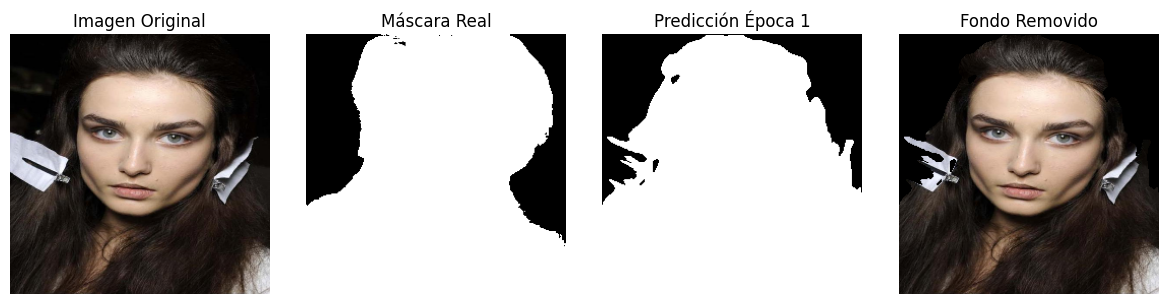

Época 2/100: TrainLoss=0.1530, ValLoss=0.1189, TrainDice=0.9761, ValDice=0.9805, TrainIoU=0.9535, ValIoU=0.9617
Learning rate actual: 1.00e-04
Modelo mejorado — guardado


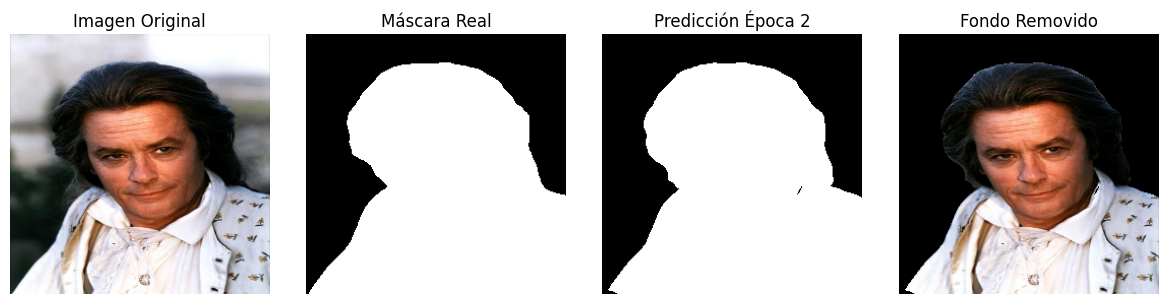

Época 3/100: TrainLoss=0.1087, ValLoss=0.1004, TrainDice=0.9812, ValDice=0.9820, TrainIoU=0.9632, ValIoU=0.9646
Learning rate actual: 1.00e-04
Modelo mejorado — guardado


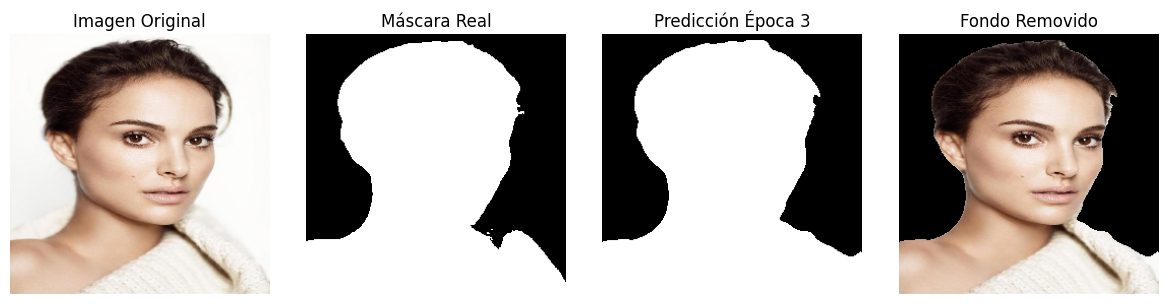

Época 4/100: TrainLoss=0.0870, ValLoss=0.0910, TrainDice=0.9841, ValDice=0.9829, TrainIoU=0.9688, ValIoU=0.9664
Learning rate actual: 1.00e-04
Modelo mejorado — guardado


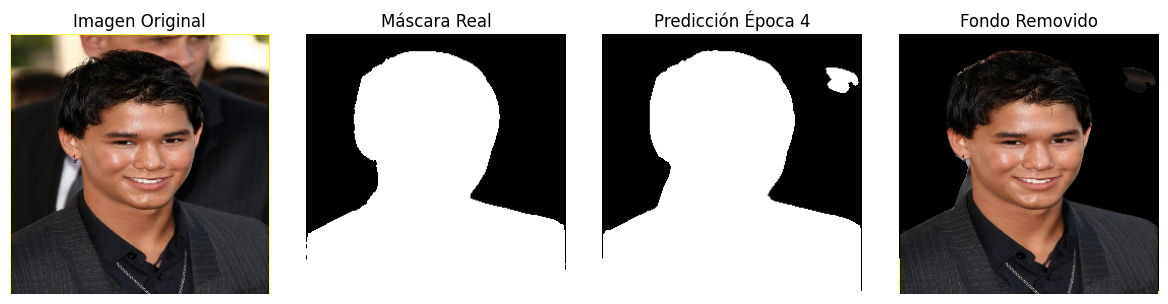

Época 5/100: TrainLoss=0.0745, ValLoss=0.0917, TrainDice=0.9858, ValDice=0.9814, TrainIoU=0.9721, ValIoU=0.9635
Learning rate actual: 1.00e-04


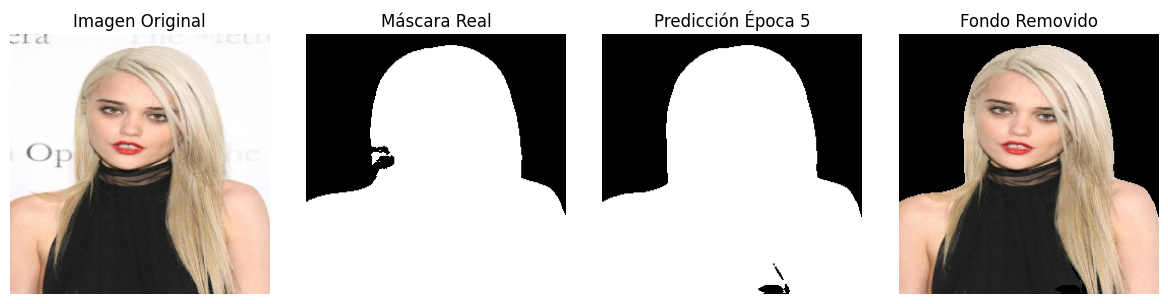

Época 6/100: TrainLoss=0.0643, ValLoss=0.0719, TrainDice=0.9875, ValDice=0.9858, TrainIoU=0.9754, ValIoU=0.9721
Learning rate actual: 1.00e-04
Modelo mejorado — guardado


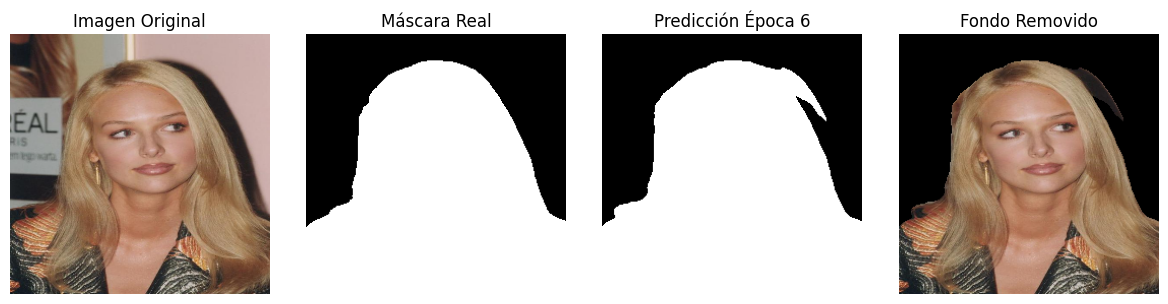

Época 7/100: TrainLoss=0.0572, ValLoss=0.0668, TrainDice=0.9888, ValDice=0.9866, TrainIoU=0.9778, ValIoU=0.9736
Learning rate actual: 1.00e-04
Modelo mejorado — guardado


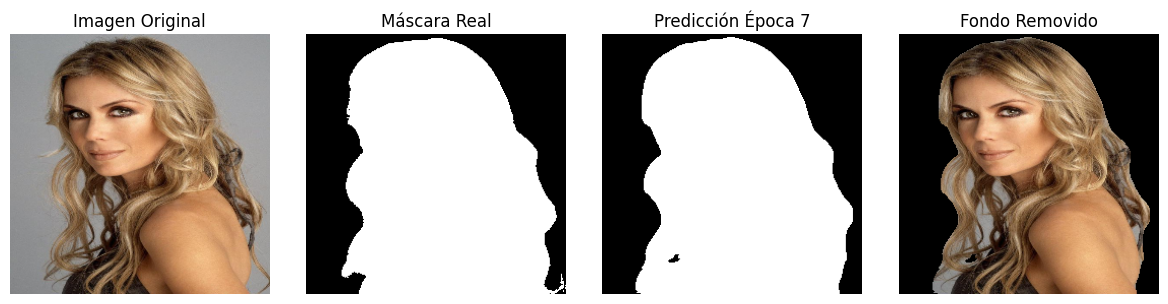

Época 8/100: TrainLoss=0.0507, ValLoss=0.0629, TrainDice=0.9900, ValDice=0.9876, TrainIoU=0.9801, ValIoU=0.9755
Learning rate actual: 1.00e-04
Modelo mejorado — guardado


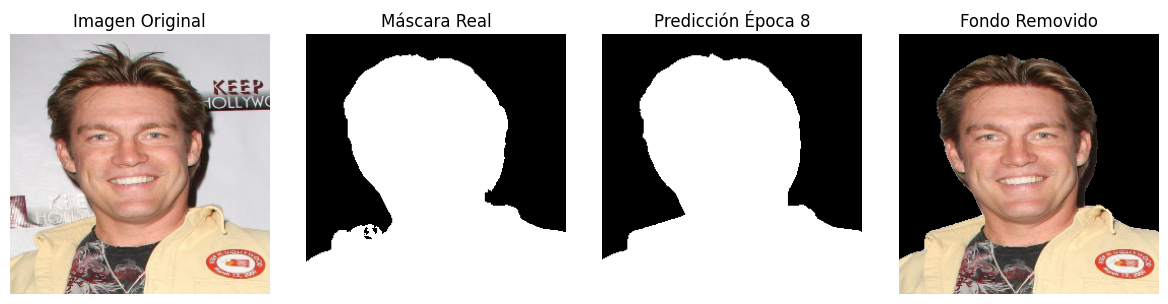

Época 9/100: TrainLoss=0.0474, ValLoss=0.0616, TrainDice=0.9905, ValDice=0.9878, TrainIoU=0.9811, ValIoU=0.9759
Learning rate actual: 1.00e-04
Modelo mejorado — guardado


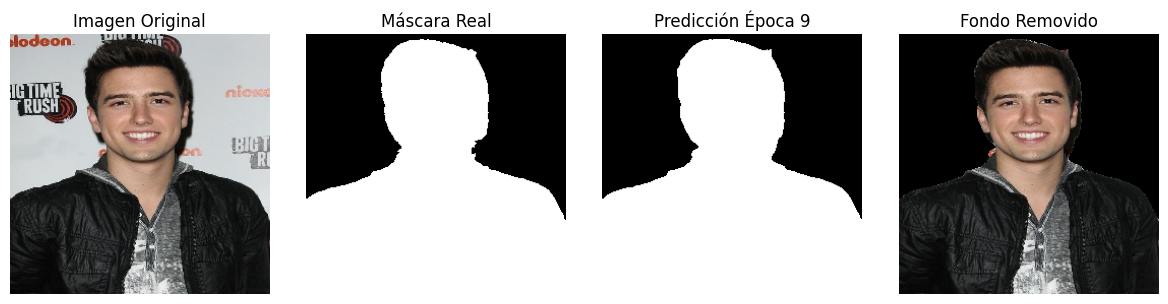

Época 10/100: TrainLoss=0.0436, ValLoss=0.0649, TrainDice=0.9912, ValDice=0.9871, TrainIoU=0.9825, ValIoU=0.9746
Learning rate actual: 1.00e-04


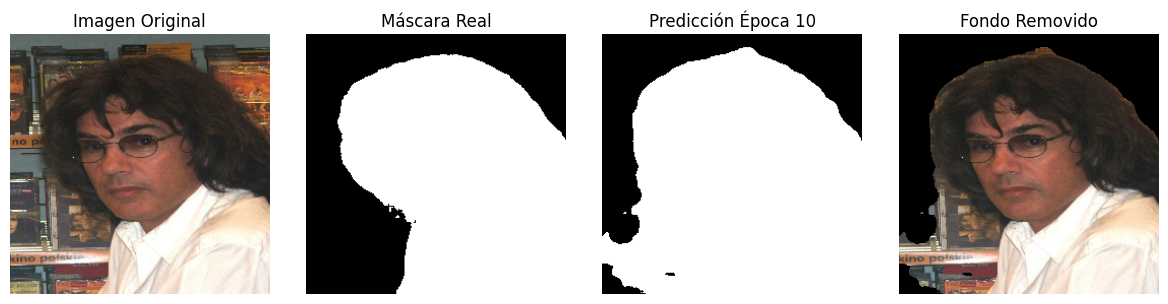

Época 11/100: TrainLoss=0.0433, ValLoss=0.0537, TrainDice=0.9911, ValDice=0.9892, TrainIoU=0.9824, ValIoU=0.9787
Learning rate actual: 1.00e-04
Modelo mejorado — guardado


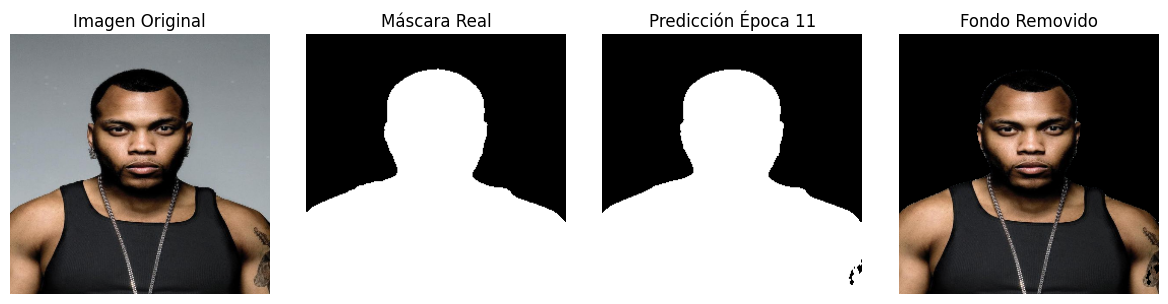

Época 12/100: TrainLoss=0.0386, ValLoss=0.0724, TrainDice=0.9921, ValDice=0.9858, TrainIoU=0.9843, ValIoU=0.9721
Learning rate actual: 1.00e-04


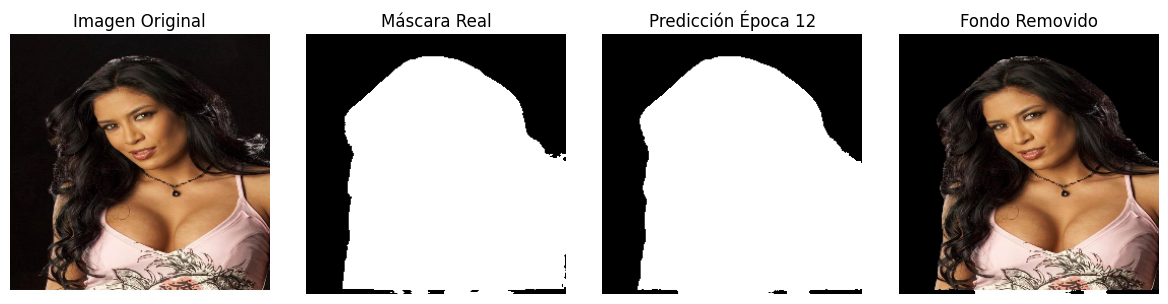

Época 13/100: TrainLoss=0.0405, ValLoss=0.0543, TrainDice=0.9916, ValDice=0.9891, TrainIoU=0.9834, ValIoU=0.9785
Learning rate actual: 1.00e-04


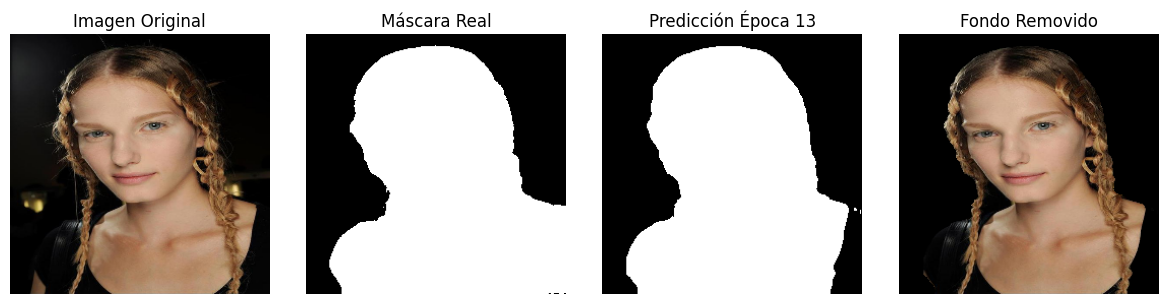

Época 14/100: TrainLoss=0.0323, ValLoss=0.0582, TrainDice=0.9933, ValDice=0.9887, TrainIoU=0.9866, ValIoU=0.9777
Learning rate actual: 1.00e-04


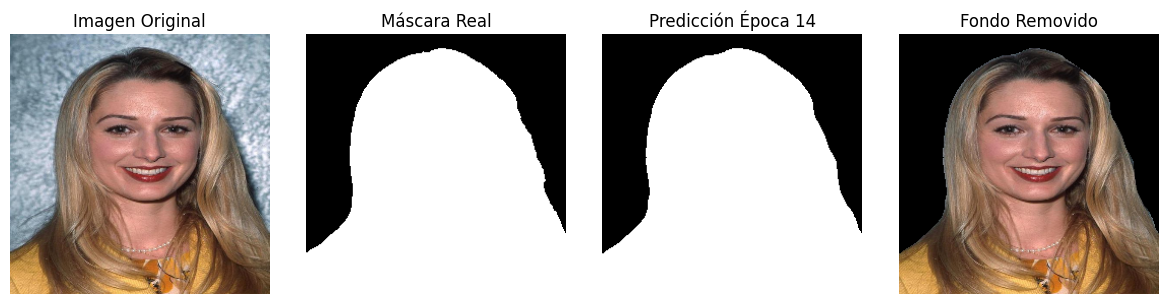

Época 15/100: TrainLoss=0.0322, ValLoss=0.0532, TrainDice=0.9933, ValDice=0.9899, TrainIoU=0.9867, ValIoU=0.9799
Learning rate actual: 1.00e-04
Modelo mejorado — guardado


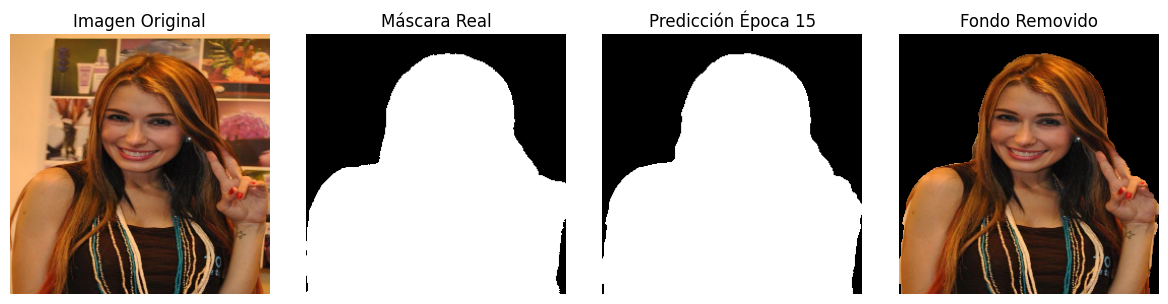

Época 16/100: TrainLoss=0.0311, ValLoss=0.0559, TrainDice=0.9935, ValDice=0.9895, TrainIoU=0.9871, ValIoU=0.9792
Learning rate actual: 1.00e-04


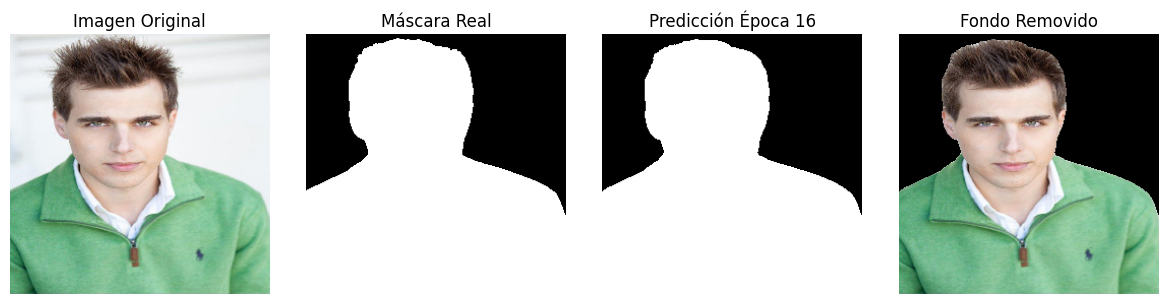

Época 17/100: TrainLoss=0.0281, ValLoss=0.0554, TrainDice=0.9941, ValDice=0.9894, TrainIoU=0.9883, ValIoU=0.9791
Learning rate actual: 1.00e-04


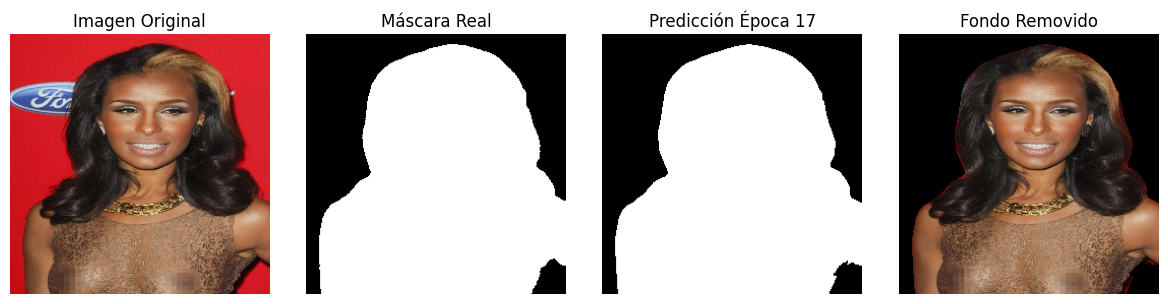

Época 18/100: TrainLoss=0.0294, ValLoss=0.0576, TrainDice=0.9938, ValDice=0.9889, TrainIoU=0.9877, ValIoU=0.9781
Learning rate actual: 1.00e-04


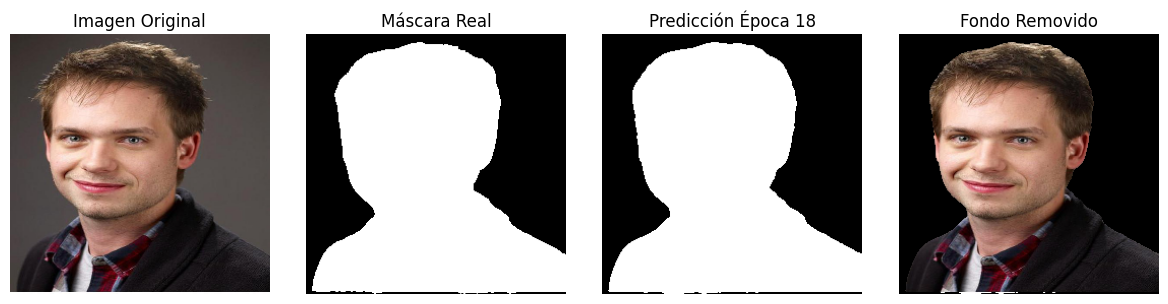

Época 19/100: TrainLoss=0.0296, ValLoss=0.0517, TrainDice=0.9938, ValDice=0.9902, TrainIoU=0.9876, ValIoU=0.9806
Learning rate actual: 1.00e-04
Modelo mejorado — guardado


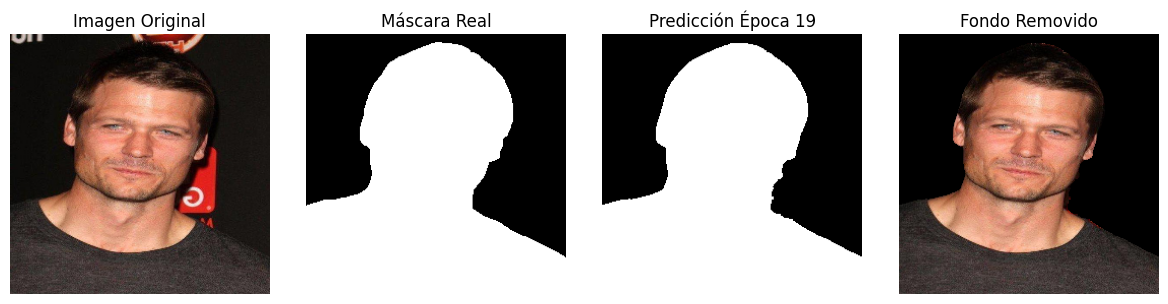

Época 20/100: TrainLoss=0.0271, ValLoss=0.0586, TrainDice=0.9943, ValDice=0.9888, TrainIoU=0.9886, ValIoU=0.9779
Learning rate actual: 1.00e-04


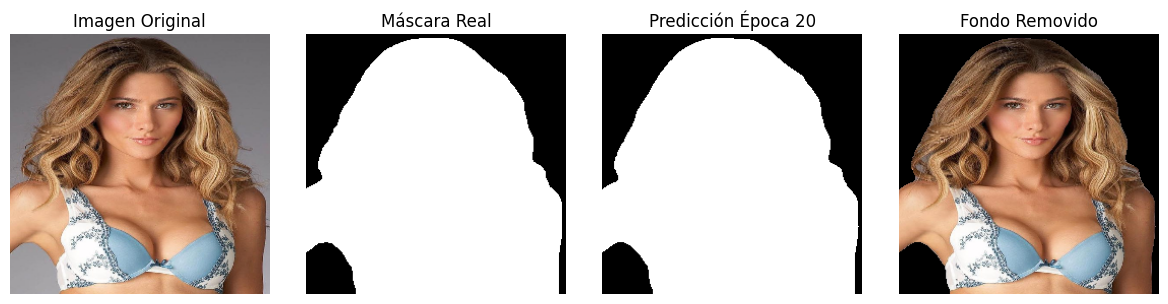

Época 21/100: TrainLoss=0.0296, ValLoss=0.0566, TrainDice=0.9938, ValDice=0.9890, TrainIoU=0.9876, ValIoU=0.9784
Learning rate actual: 1.00e-04


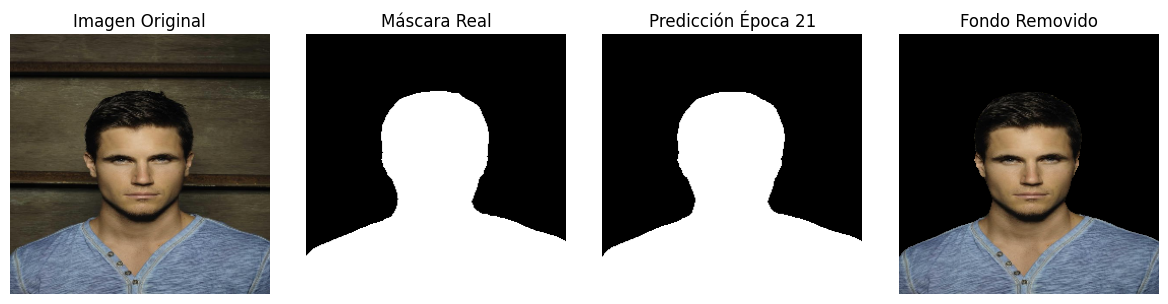

Época 22/100: TrainLoss=0.0247, ValLoss=0.0523, TrainDice=0.9947, ValDice=0.9903, TrainIoU=0.9895, ValIoU=0.9807
Learning rate actual: 1.00e-04


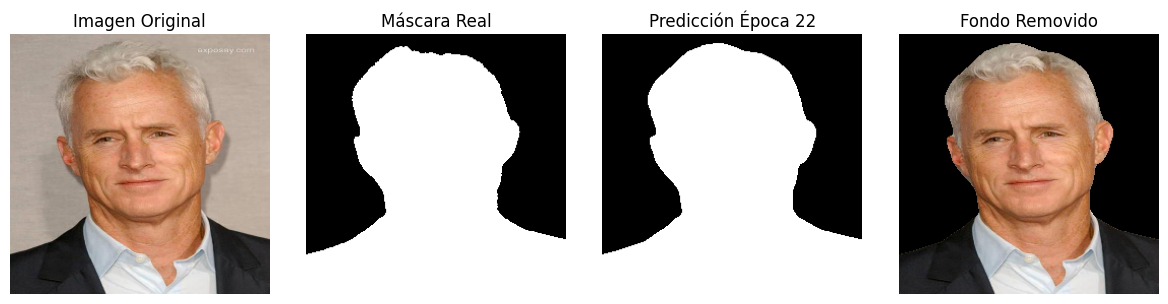

Época 23/100: TrainLoss=0.0213, ValLoss=0.0563, TrainDice=0.9955, ValDice=0.9896, TrainIoU=0.9909, ValIoU=0.9795
Learning rate actual: 1.00e-04


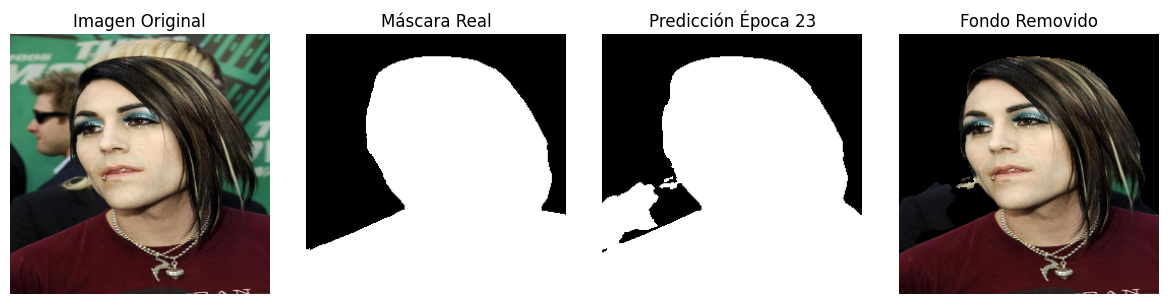

Época 24/100: TrainLoss=0.0187, ValLoss=0.0495, TrainDice=0.9960, ValDice=0.9912, TrainIoU=0.9920, ValIoU=0.9825
Learning rate actual: 5.00e-05
Modelo mejorado — guardado


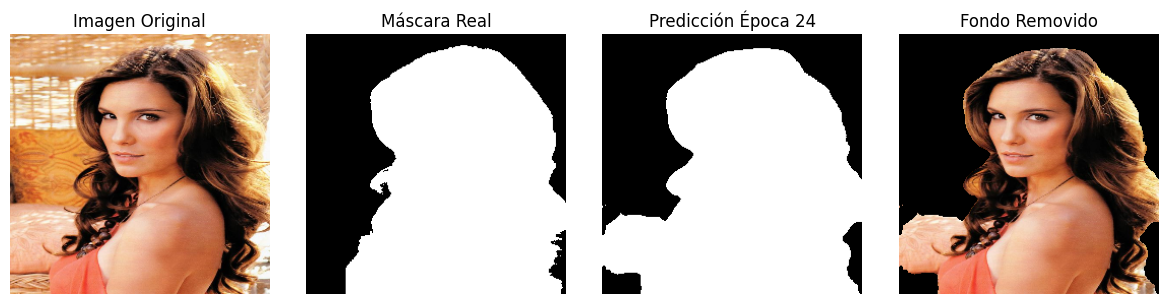

Época 25/100: TrainLoss=0.0173, ValLoss=0.0502, TrainDice=0.9962, ValDice=0.9911, TrainIoU=0.9925, ValIoU=0.9823
Learning rate actual: 5.00e-05


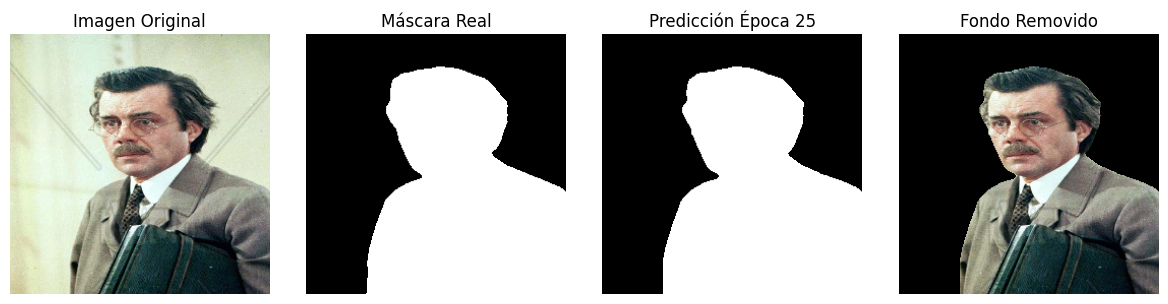

Época 26/100: TrainLoss=0.0166, ValLoss=0.0508, TrainDice=0.9964, ValDice=0.9911, TrainIoU=0.9928, ValIoU=0.9824
Learning rate actual: 5.00e-05


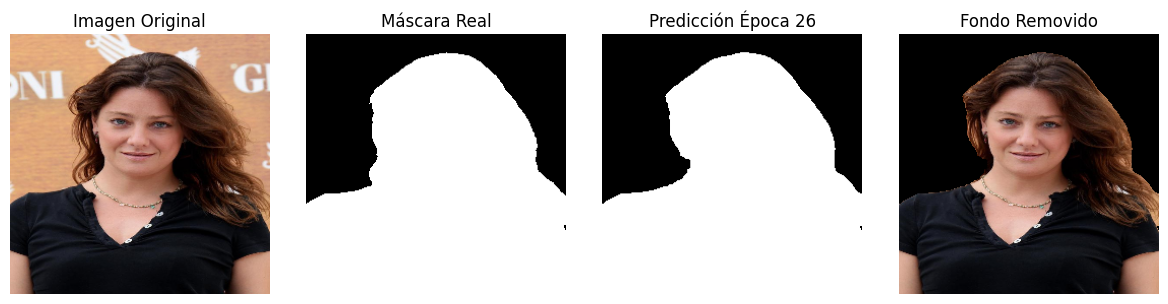

Época 27/100: TrainLoss=0.0164, ValLoss=0.0531, TrainDice=0.9964, ValDice=0.9909, TrainIoU=0.9928, ValIoU=0.9821
Learning rate actual: 5.00e-05


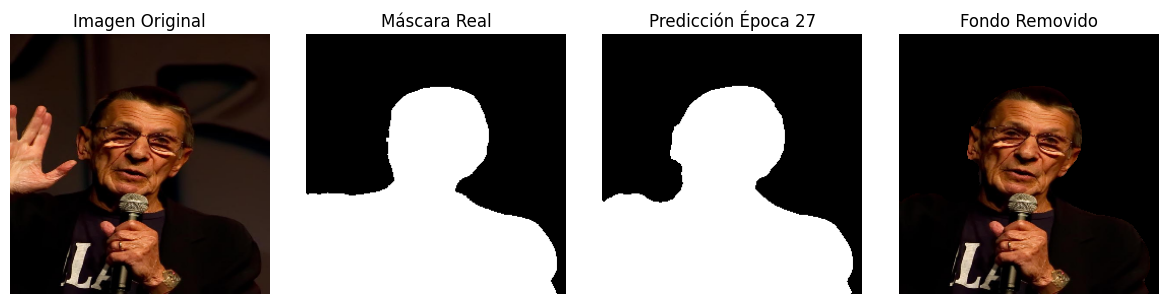

Época 28/100: TrainLoss=0.0160, ValLoss=0.0528, TrainDice=0.9965, ValDice=0.9910, TrainIoU=0.9930, ValIoU=0.9821
Learning rate actual: 5.00e-05


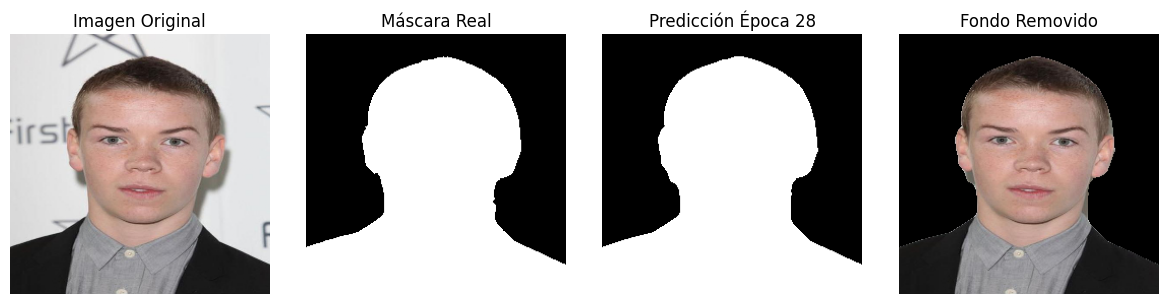

Época 29/100: TrainLoss=0.0146, ValLoss=0.0523, TrainDice=0.9968, ValDice=0.9912, TrainIoU=0.9936, ValIoU=0.9826
Learning rate actual: 2.50e-05
Early Stopping activado


In [ ]:
import torch, numpy as np, matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)
criterion = DiceBCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Scheduler que reduce el LR cuando la validación no mejora
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

epochs = 100
patience = 5
best_val_loss = float('inf')
no_improve = 0

train_losses, val_losses = [], []
train_dices, val_dices = [], []
train_ious, val_ious = [], []

def dice_coefficient(preds, targets, smooth=1e-6):
    preds = (preds > 0.5).float()
    intersection = (preds * targets).sum()
    return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

def iou_score(preds, targets, smooth=1e-6):
    preds = (preds > 0.5).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection + smooth) / (union + smooth)


# Loop de entrenaemiento
for epoch in range(epochs):
    model.train()
    train_loss, train_dice, train_iou = 0, 0, 0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += dice_coefficient(preds, masks).item()
        train_iou += iou_score(preds, masks).item()

    train_loss /= len(train_loader)
    train_dice /= len(train_loader)
    train_iou /= len(train_loader)
    train_losses.append(train_loss)
    train_dices.append(train_dice)
    train_ious.append(train_iou)

    # Validación
    model.eval()
    val_loss, val_dice, val_iou = 0, 0, 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            val_loss += criterion(preds, masks).item()
            val_dice += dice_coefficient(preds, masks).item()
            val_iou += iou_score(preds, masks).item()

    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    val_iou /= len(val_loader)
    val_losses.append(val_loss)
    val_dices.append(val_dice)
    val_ious.append(val_iou)

    print(f"Época {epoch+1}/{epochs}: "
          f"TrainLoss={train_loss:.4f}, ValLoss={val_loss:.4f}, "
          f"TrainDice={train_dice:.4f}, ValDice={val_dice:.4f}, "
          f"TrainIoU={train_iou:.4f}, ValIoU={val_iou:.4f}")
    print(f"Learning rate actual: {optimizer.param_groups[0]['lr']:.2e}")


    scheduler.step(val_loss)
    # Guardar mejor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), "best_unet_human_256.pth")
        print("Modelo mejorado — guardado")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early Stopping activado")
            break

    # Visualizar predicción aleatoria con máscara aplicada
    with torch.no_grad():
        idx = np.random.randint(len(val_dataset))
        img, mask = val_dataset[idx]
        img_tensor = img.unsqueeze(0).to(device)
        pred = model(img_tensor).cpu().squeeze().numpy()
        pred_mask = (pred > 0.5).astype(np.uint8)

        img_np = np.transpose(img.numpy(), (1,2,0))
        masked_img = img_np * pred_mask[..., None]

        fig, axes = plt.subplots(1, 4, figsize=(12,3))
        axes[0].imshow(img_np)
        axes[0].set_title("Imagen Original")
        axes[1].imshow(mask.squeeze(), cmap="gray")
        axes[1].set_title("Máscara Real")
        axes[2].imshow(pred_mask, cmap="gray")
        axes[2].set_title(f"Predicción Época {epoch+1}")
        axes[3].imshow(masked_img)
        axes[3].set_title("Fondo Removido")
        for a in axes: a.axis("off")
        plt.tight_layout()
        plt.show()

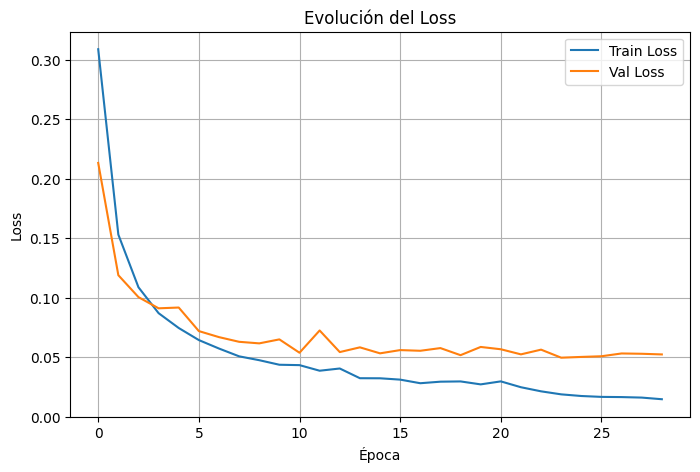

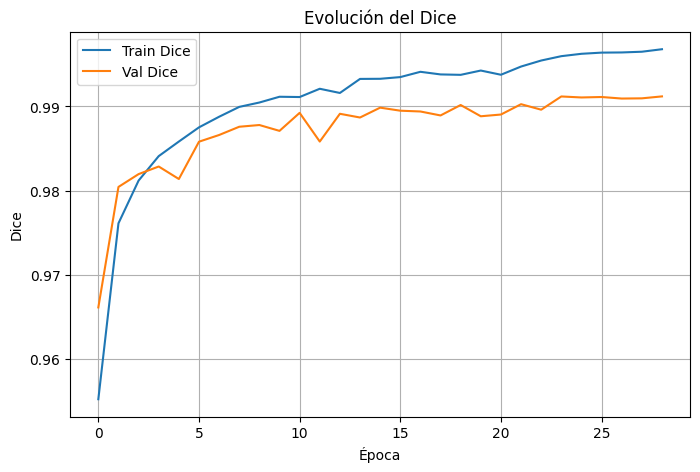

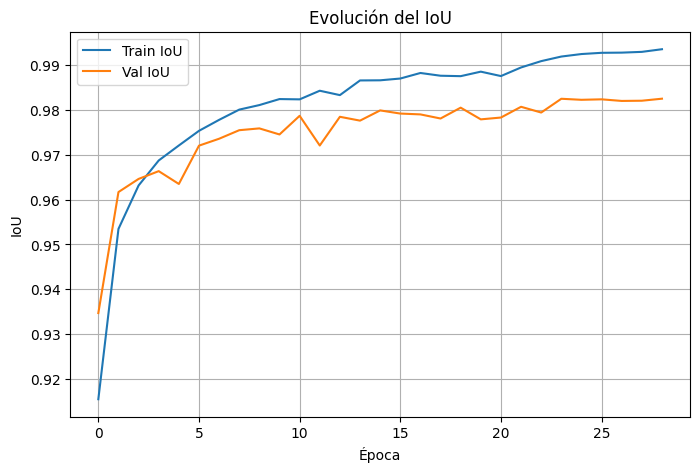

In [ ]:
# Gráfico de Loss
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Evolución del Loss")
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de Dice
plt.figure(figsize=(8,5))
plt.plot(train_dices, label="Train Dice")
plt.plot(val_dices, label="Val Dice")
plt.xlabel("Época")
plt.ylabel("Dice")
plt.title("Evolución del Dice")
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de IoU
plt.figure(figsize=(8,5))
plt.plot(train_ious, label="Train IoU")
plt.plot(val_ious, label="Val IoU")
plt.xlabel("Época")
plt.ylabel("IoU")
plt.title("Evolución del IoU")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Cargar mejor modelo
model.load_state_dict(torch.load("best_unet_human_256.pth"))
model.eval()

criterion = nn.BCELoss().to(device)

all_preds, all_masks = [], []
BCE = 0.0
count = 0

with torch.no_grad():
    for imgs, masks in test_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        # Cross entropy loss (BCE)
        loss = criterion(preds, masks)
        BCE += loss.item()
        count += 1
        all_preds.append(preds.cpu())
        all_masks.append(masks.cpu())

# Promediar pérdida
BCE /= count

all_preds = torch.cat(all_preds).numpy()
all_masks = torch.cat(all_masks).numpy()
A
# Binarizar predicciones
all_preds_bin = (all_preds > 0.5).astype(np.uint8)

# Métricas
dice = 2 * (all_preds_bin.flatten() * all_masks.flatten()).sum() / \
       (all_preds_bin.sum() + all_masks.sum() + 1e-6)
iou = jaccard_score(all_masks.flatten(), all_preds_bin.flatten())
precision = precision_score(all_masks.flatten(), all_preds_bin.flatten())
recall = recall_score(all_masks.flatten(), all_preds_bin.flatten())

print("Test Metrics:")
print(f"Cross Entropy (BCE) Loss: {BCE:.4f} | Dice: {dice:.4f} | IoU: {iou:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")


Test Metrics:
Cross Entropy (BCE) Loss: 0.0395 | Dice: 0.9911 | IoU: 0.9823 | Precision: 0.9896 | Recall: 0.9926
